<a href="https://colab.research.google.com/github/davidsjohnson/evalxai_studies/blob/final-newds/notebooks/blockies_datasets_review.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Blockies Dataset

This notebook download the blockies dataset and the corresponding trained model.  This is then used to evaluate the model on all datasets.  

Additionally, we provide a review of the various Blocky traits, to review the distributions between ill and healthy Blockies.

In [1]:
import pathlib
import os
import sys
from pathlib import Path
import tarfile
import random

import numpy as np

import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
from torchvision import transforms as T

from PIL import Image

import matplotlib.pyplot as plt
import seaborn as sns

torch.backends.cudnn.benchmark = True

In [2]:
CLASSES = ['Healthy', 'OCDegen']

modeltype = 'mobilenet'

ds = 'sick_ones_bendbias_v3_2class_normal'
eval_ds = 'sick_ones_bendbias_v3_2class_variation'

random_state = 42

# Setup and Load Datasets

In [3]:
# data downloading and dataset utilities

def download_file(url, file_name, cache_dir="data", extract=True, force_download=False, archive_folder=None):
    # Ensure the cache directory exists
    os.makedirs(cache_dir, exist_ok=True)
    file_path = os.path.join(cache_dir, file_name)

    # Download the file
    if not os.path.exists(file_path) or force_download:
      torch.hub.download_url_to_file(url, file_path)
      print(f"File downloaded to: {file_path}")
    else:
      print(f"File already exists at: {file_path}")

    if extract:
      with tarfile.open(file_path, "r:gz") as tar:
          tar.extractall(path=cache_dir)
      print(f"File extracted to: {cache_dir}")
      return Path(cache_dir) / archive_folder if archive_folder is not None else Path(cache_dir)

    return Path(file_path)

def load_dataframe(data_dir, dataset):
  data_dir = data_dir / dataset
  df = pd.read_json(data_dir / 'parameters.jsonl', lines=True)
  df['filename'] = df['id'] + '.png'
  df['ill'] = df['ill'].astype(int).astype(str)
  return df

class ImageDataset(Dataset):
    def __init__(self, df, data_dir, transform=None):
        self.df = df
        self.data_dir = data_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = os.path.join(self.data_dir, self.df.iloc[idx]['filename'])
        image = Image.open(img_path).convert('RGB')
        label = int(self.df.iloc[idx]['ill'])

        if self.transform:
            image = self.transform(image)

        return image, label

## Load Dataset and Dataloaders


In [4]:
# download data direcly from sciebo
# (or setup own data location if prefered)

data_dir = download_file(url="https://osf.io/download/kexzt/?view_only=adcc520b88cc4ea3b8236c5178ba3ab5",
                         file_name="blockies_datasets.tar.gz",
                         cache_dir='/content/data', # change this if not using Colab
                         extract=True,
                         force_download=False,
                         archive_folder='blockies_datasets')
data_dir

100%|██████████| 1.00G/1.00G [00:28<00:00, 37.2MB/s]


File downloaded to: /content/data/blockies_datasets.tar.gz
File extracted to: /content/data


PosixPath('/content/data/blockies_datasets')

In [5]:
ds_dir = data_dir / ds
eval_ds_dir = data_dir / eval_ds
ds_dir, eval_ds_dir

(PosixPath('/content/data/blockies_datasets/sick_ones_bendbias_v3_2class_normal'),
 PosixPath('/content/data/blockies_datasets/sick_ones_bendbias_v3_2class_variation'))

In [6]:
# 2 class dataset
mean = [0.8068, 0.7830, 0.8005]
std = [0.1093, 0.1136, 0.1029]


transform = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=mean, std=std)
])


train_df = load_dataframe(ds_dir, 'train')
val_df = load_dataframe(ds_dir, 'validation')
test_df = load_dataframe(ds_dir, 'test')
eval_df = load_dataframe(eval_ds_dir, 'test')

print(len(train_df), len(val_df), len(test_df), len(eval_df))


train_dataset = ImageDataset(train_df, ds_dir / 'train', transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=False,
                              num_workers=6, pin_memory=True)

val_dataset = ImageDataset(val_df,  ds_dir / 'validation', transform=transform)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False,
                            num_workers=6, pin_memory=True)

test_dataset = ImageDataset(test_df,  ds_dir / 'test', transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False,
                             num_workers=6, pin_memory=True)

eval_dataset = ImageDataset(eval_df,  eval_ds_dir / 'test', transform=transform)
eval_dataloader = DataLoader(eval_dataset, batch_size=1, shuffle=False,
                             num_workers=6, pin_memory=True)

40000 1000 3000 3000


# Model Loading and Evaluation





In [7]:
def load_mobilenetv2(num_classes, pretrained=True, checkpoint_path=None):
  """Loads a MobileNetV2 model, optionally loading from a checkpoint.

  Args:
    num_classes: The number of output classes.
    pretrained: Whether to load the pre-trained weights.
    checkpoint_path: Path to a checkpoint file to load.

  Returns:
    A MobileNetV2 model.
  """
  model = models.mobilenet_v2(weights=None if not pretrained else 'DEFAULT')
  model.classifier[1] = nn.Linear(model.last_channel, num_classes)

  if checkpoint_path:
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint)
    print(f"Loaded checkpoint from: {checkpoint_path}")

  return model

In [8]:
def set_seed(seed):
  """
  Sets random seeds for reproducibility.
  """
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False


def evaluate_model(model, dataloader, criterion, device):
    model.eval()  # Set model to evaluation mode
    running_loss = 0.0
    correct = 0
    total = 0

    preds = []
    with torch.no_grad():  # Disable gradient calculation
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Track loss and accuracy
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            preds.extend(predicted.cpu().numpy())
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    avg_loss = running_loss / len(dataloader)
    accuracy = correct / total

    print(f"Evaluation Loss: {avg_loss:.4f}, Evaluation Accuracy: {accuracy:.4f}")
    return avg_loss, accuracy, np.array(preds)

In [9]:
checkpoint_path = download_file(url='https://osf.io/download/5crqh/?view_only=adcc520b88cc4ea3b8236c5178ba3ab5',
                                file_name='best_model.pth',
                                cache_dir='/content/model/mobilenetv2_checkpoint', # change this if not using Colab
                                extract=False,
                                force_download=True)
checkpoint_path

100%|██████████| 8.73M/8.73M [00:00<00:00, 9.80MB/s]

File downloaded to: /content/model/mobilenetv2_checkpoint/best_model.pth


PosixPath('/content/model/mobilenetv2_checkpoint/best_model.pth')

In [10]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Evaluate Model

In [11]:
# load best model and evaluate
model = load_mobilenetv2(num_classes=len(CLASSES),
                         pretrained=False,
                         checkpoint_path=checkpoint_path)
model.to(device)

_ = evaluate_model(model, train_dataloader, criterion, device)
_ = evaluate_model(model, val_dataloader, criterion, device)
_ = evaluate_model(model, test_dataloader, criterion, device)
_ = evaluate_model(model, eval_dataloader, criterion, device)

<ipython-input-7-8ca1eb820737>:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


Loaded checkpoint from: /content/model/mobilenetv2_checkpoint/best_model.pth
Evaluation Loss: 0.0913, Evaluation Accuracy: 0.9682
Evaluation Loss: 0.2097, Evaluation Accuracy: 0.9150
Evaluation Loss: 0.2286, Evaluation Accuracy: 0.9043
Evaluation Loss: 0.9194, Evaluation Accuracy: 0.6937


# Parameter Review

## Preprocess Data Frame

In [12]:
# Get pred for Eval Set
_, _, preds = evaluate_model(model, eval_dataloader, criterion, device)
preds = np.array(preds)
eval_df['pred'] = preds

corr_pred = eval_df['pred'] == eval_df['ill'].astype(int)
print(f'Acc: {corr_pred.astype(int).mean():.4f}')

Evaluation Loss: 0.9194, Evaluation Accuracy: 0.6937
Acc: 0.6937


In [13]:
# add Sphere Diff value for plotting
eval_df['sphere_diff'] = np.abs(eval_df['spherical'] - eval_df['ill_spherical'])

# add label names for better plots
eval_df['ill_label'] = eval_df['ill'].astype(int).map({0: 'Healthy', 1: 'OCDegen'})
eval_df['pred_label'] = eval_df['pred'].astype(int).map({0: 'Healthy', 1: 'OC Degen'})

In [14]:
eval_df.sample(5)

,obj_name,labeling_error,spherical,ill,ill_chars,ill_spherical,num_diff,bending,obj_rotation_roll,obj_rotation_pitch,...,original_id,_attributes_status,label,__module__,__name__,filename,pred,sphere_diff,ill_label,pred_label
2194,peaky,False,0.327616,0,"[mutation_color, med_bend]",0.494287,1,0.169542,0.271833,0.988029,...,NaN,"{'obj_name': 'sampled', 'labeling_error': 'sam...",peaky,two4two.scene_parameters,SceneParameters,651a59b5-2fba-43d0-bb8e-a8659453f74a.png,0,0.166671,Healthy,Healthy
239,peaky,False,0.888648,1,"[high_bend, high_sphere_diff, mutation_color]",0.203976,2,0.359989,-0.181862,-0.991530,...,NaN,"{'obj_name': 'sampled', 'labeling_error': 'sam...",peaky,two4two.scene_parameters,SceneParameters,4c5b77fe-bc52-4514-ba15-1b92c6074935.png,1,0.684672,OCDegen,OC Degen
2680,peaky,False,0.989477,1,"[high_sphere_diff, high_bend, mutation_color]",0.360673,2,0.240829,-0.166773,-0.341032,...,NaN,"{'obj_name': 'sampled', 'labeling_error': 'sam...",peaky,two4two.scene_parameters,SceneParameters,beafa2bd-6164-4240-b5b9-1e90c8e0990e.png,1,0.628804,OCDegen,OC Degen
1394,peaky,False,0.038291,0,[mutation_color],0.228000,2,0.063780,-0.438684,-1.003463,...,NaN,"{'obj_name': 'sampled', 'labeling_error': 'sam...",peaky,two4two.scene_parameters,SceneParameters,18f6e1c1-f6bd-45fa-a802-5ccd2724e4b3.png,0,0.189709,Healthy,Healthy
1928,peaky,False,0.201899,1,"[high_bend, stretchy, high_sphere_diff]",0.885330,3,0.302600,-0.725044,-0.324572,...,NaN,"{'obj_name': 'sampled', 'labeling_error': 'sam...",peaky,two4two.scene_parameters,SceneParameters,9df9e5da-fc5d-4740-8159-f2810e3975dc.png,1,0.683431,OCDegen,OC Degen


In [15]:
eval_df.columns

Index(['obj_name', 'labeling_error', 'spherical', 'ill', 'ill_chars',
       'ill_spherical', 'num_diff', 'bending', 'obj_rotation_roll',
       'obj_rotation_pitch', 'obj_rotation_yaw', 'fliplr', 'position_x',
       'position_y', 'arm_position', 'obj_color', 'obj_color_rgba', 'bg_color',
       'bg_color_rgba', 'resolution', 'id', 'original_id',
       '_attributes_status', 'label', '__module__', '__name__', 'filename',
       'pred', 'sphere_diff', 'ill_label', 'pred_label'],
      dtype='object')

## Review of Data Distributions for Experimental Dataset

Here we plot the values sample for various traits of Blockies.  These values are use to generate the blockies in Blender

### Traits with Biomarkers of OCDegen

Here are the 4 Blocky traits that server as biomarkers for OCDegen. You'll see that the distrutions of each are distinct.

Since Healthy blockies can have up to one biomarker, you will see some overlap in the distributions


**Sphere Difference**

This value represents the variation in main and secondary bone shapes.  Strong variation is a biomarker of OCDegen

Text(0.5, 0, 'Sphere Diff')

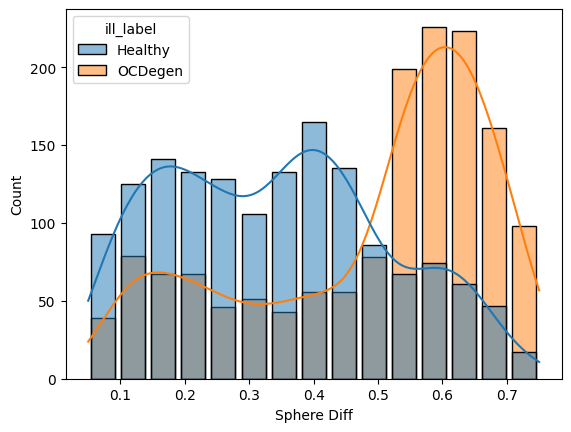

In [16]:
g = sns.histplot(data=eval_df, x='sphere_diff', hue='ill_label', multiple='layer', shrink=0.8, kde=True)
plt.xlabel('Sphere Diff')

**Main Bone Shape**

This value represents the shape of the main bones, typically it ranges between 0 and 1.  But value above 1 are a biomarker of OCDegen and results in more of a pointed shaped when rendered.

Text(0.5, 0, 'Main Bone Shape')

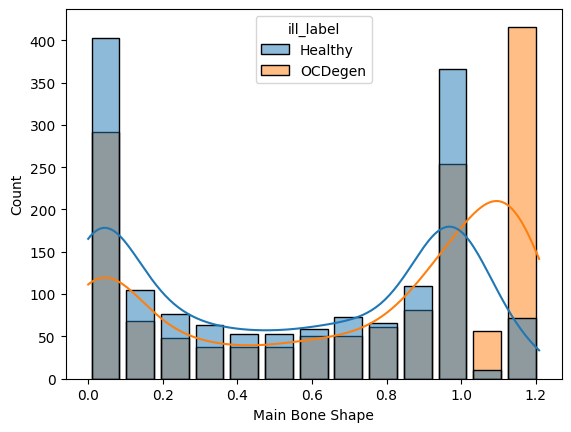

In [17]:
g = sns.histplot(data=eval_df, x='spherical', hue='ill_label', multiple='layer', shrink=0.8, kde=True)
plt.xlabel('Main Bone Shape')

**Spine Bending**

This value represents the amount of bend in the Blocky posture.  Strong bending is a biomarker of OCDegen

Text(0.5, 0, 'Bending')

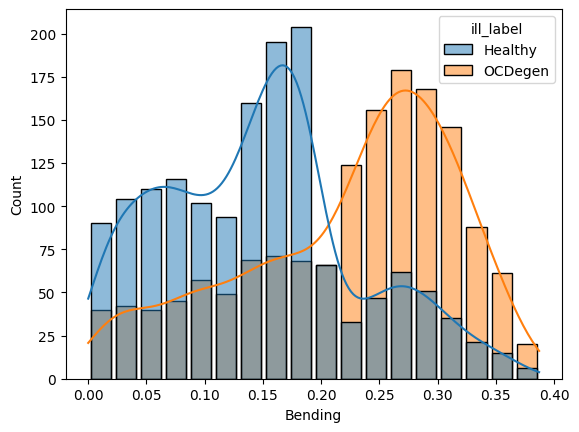

In [18]:
g = sns.histplot(data=eval_df, x='bending', hue='ill_label', multiple='layer', shrink=0.8, kde=True)
plt.xlabel('Bending')

**Leg Position**

This value represents position of the Blocky legs and ranges from 0 to 1. Values less than 0.5 have the legs pulled back and head peaking out, while above 0.5 means the legs are extended past the head.  Extended legs (values above 0.5) are a biomarker of OCDegen

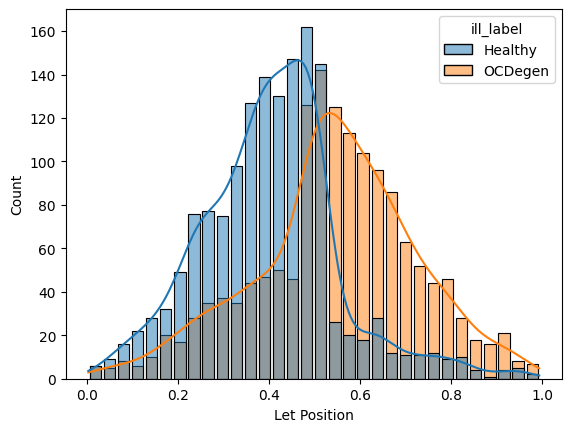

In [19]:
g = sns.histplot(data=eval_df, x='arm_position', hue='ill_label', multiple='layer', shrink=0.8, kde=True)
plt.xlabel('Let Position');

### Traits without Biomarkers of OCDegen

The traits below have no difference in the sampling distrubution between healthy and ill Blockies.  But could be used to induce new biases for evaluating XAI.

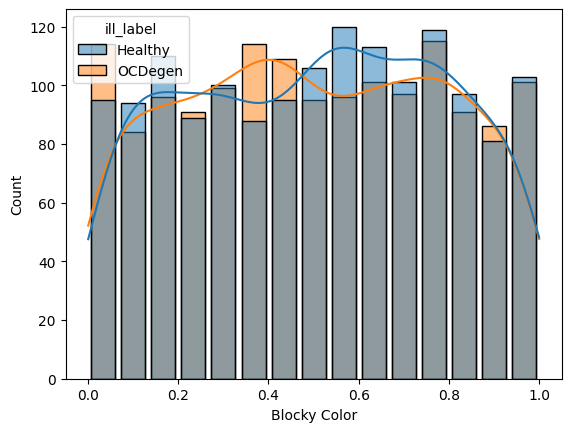

In [20]:
g = sns.histplot(data=eval_df, x='obj_color', hue='ill_label', multiple='layer', shrink=0.8, kde=True)
plt.xlabel('Blocky Color');

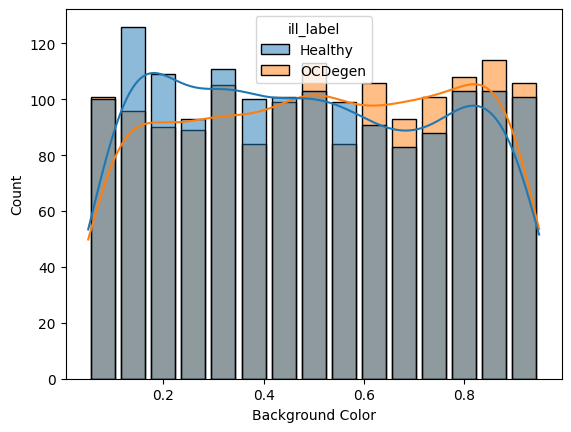

In [21]:
g = sns.histplot(data=eval_df, x='bg_color', hue='ill_label', multiple='layer', shrink=0.8, kde=True)
plt.xlabel('Background Color');

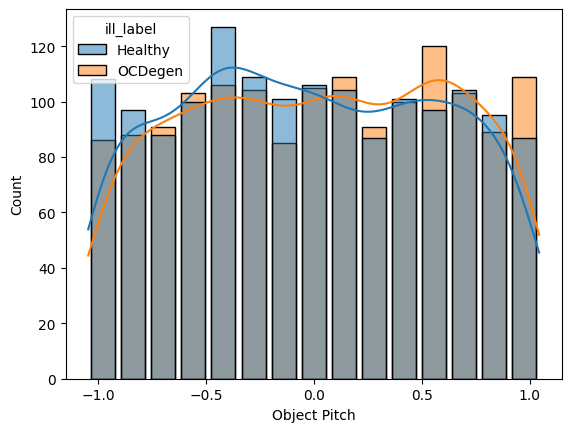

In [22]:
# see all obj_rotation_roll and obj_rotation_yaw
g = sns.histplot(data=eval_df, x='obj_rotation_pitch', hue='ill_label', multiple='layer', shrink=0.8, kde=True)
plt.xlabel('Object Pitch');